# RSNA Screening Mammography Breast Cancer Detection (EDA)
---

Welcome to this notebook on *exploratory data analysis (EDA)* for the competition **RSNA Screening Mammography Breast Cancer Detection**. In this notebook, we will be using a dataset containing images of different patients in dicom format, along with the corresponding meta data for each patient in a csv table. Our goal is to understand the characteristics of the data and identify any potential issues or inconsistencies that may need to be addressed before moving on to the modeling phase.

To begin, we will load the data and take a look at the structure of the images and meta data. We will also perform some basic statistical analysis to get a sense of the overall distribution and range of values in the data. Additionally, we will visualize the data in various ways to help us gain a better understanding of the relationships between different variables and the underlying patterns present in the data.

By the end of this notebook, we should have a good understanding of the data and be prepared to move on to the next steps in the machine learning process. Let's get started!

*Link to the competition dataset:*
https://www.kaggle.com/competitions/rsna-breast-cancer-detection/data

*This notebook has been inspired by the work of Laura Fink:* https://www.kaggle.com/code/allunia/rsna-breast-cancer-eda

# Import packages

In [1]:
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: pydicom
    Found existing installation: pydicom 2.3.0
    Uninstalling pydicom-2.3.0:
      Successfully uninstalled pydicom-2.3.0


In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Manage files
import pydicom
from os import listdir

from scipy.stats import mode

# Others
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

!pip install -qU python-gdcm pydicom pylibjpeg

# Exploring the patient metadata

The test set only contains an example for a single patient. Let's only focus on the train set.

In [3]:
filepath = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
data = pd.read_csv(filepath)
data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


## Missing values 

In [4]:
data.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

There are missing values only for age, BIRADS and density.

## Basic information

In [5]:
num_patients = data['patient_id'].nunique()
min_patient_age = int(data['age'].min())
max_patient_age = int(data['age'].max())
groupby_id = data.groupby('patient_id')['cancer'].apply(lambda x: x.unique()[0])
n_negative = (groupby_id == 0).sum()
n_positive = (groupby_id == 1).sum()

print(f"There are {num_patients} different patients in the train set.\n")
print(f"The younger patient is {min_patient_age} years old.")
print(f"The older patient is {max_patient_age} years old.\n")
print(f"There are {n_negative} patients negative to breast cancer. Ratio = {n_negative / num_patients}")
print(f"There are {n_positive} patients positive to breast cancer. Ratio = {n_positive / num_patients}")

There are 11913 different patients in the train set.

The younger patient is 26 years old.
The older patient is 89 years old.

There are 11665 patients negative to breast cancer. Ratio = 0.9791824057752035
There are 248 patients positive to breast cancer. Ratio = 0.02081759422479644


The classification problem is very unbalanced. About 2% of the patients are in the positive class which means that we will have a minority of cancer examples.

## Age distribution

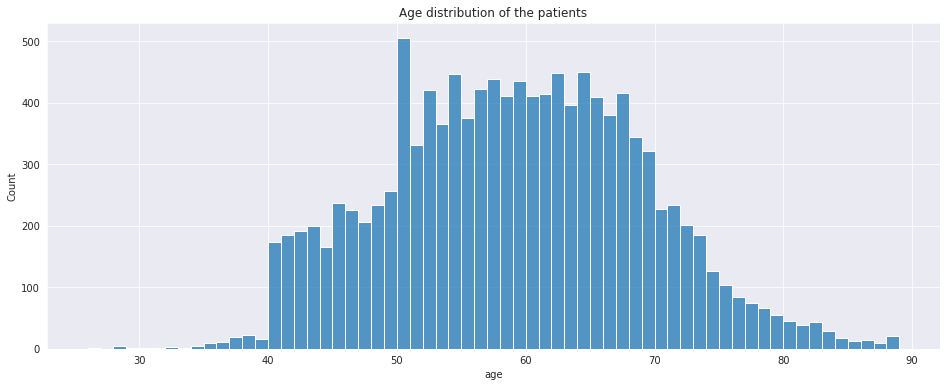

In [6]:
ages = data[data['age'].isna() == False].groupby('patient_id')['age'] \
    .apply(lambda x: x.unique()[0])

plt.figure(figsize=(16, 6))
sns.histplot(ages, bins=63)
plt.title("Age distribution of the patients")
plt.show()

In [7]:
# Statistics
print("Mean:", ages.mean())
print("Std:", ages.std())
print("Q1:", ages.quantile(0.25))
print("Median:", ages.median())
print("Q3:", ages.quantile(0.75))
print("Mode:", ages.mode()[0])

Mean: 58.63821923561529
Std: 9.885104442511699
Q1: 51.0
Median: 59.0
Q3: 66.0
Mode: 50.0


### Insights
* Most of the patients are **older than 40 years old**
* There is a a **peak at the age of 50**
* Then, there is a **plateau until 70 years old** before the count of patients drops.

## Number of images per patient

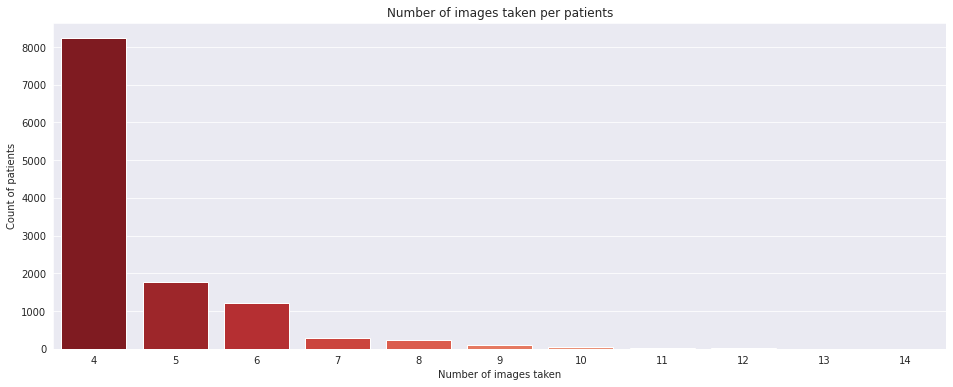

In [8]:
n_images_per_patient = data['patient_id'].value_counts()
plt.figure(figsize=(16, 6))
sns.countplot(n_images_per_patient, palette='Reds_r')
plt.title("Number of images taken per patients")
plt.xlabel('Number of images taken')
plt.ylabel('Count of patients')
plt.show()

### Insights
* Most of the patients have 4 images (2 views per side). However there are sometimes more of them.

## Image features

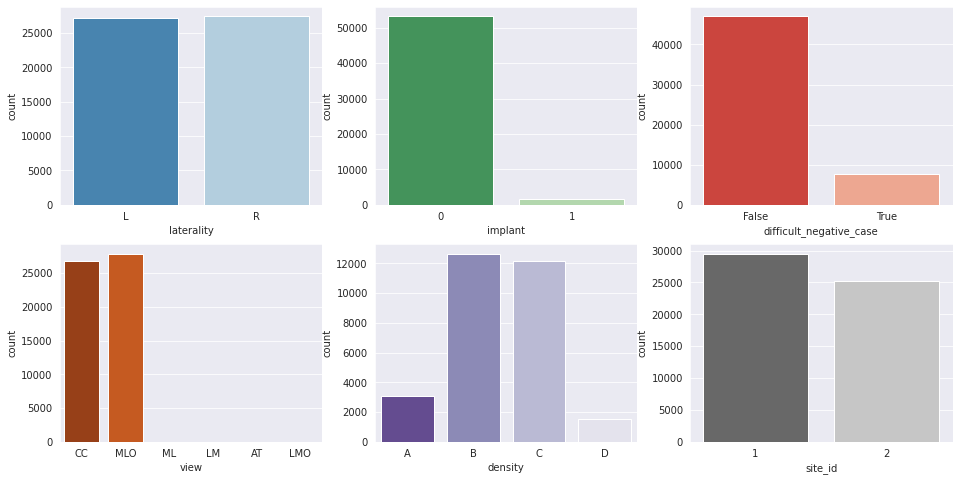

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
sns.countplot(data['laterality'], palette='Blues_r', ax=ax[0, 0])
sns.countplot(data['implant'], palette='Greens_r', ax=ax[0, 1])
sns.countplot(data['difficult_negative_case'], palette='Reds_r', ax=ax[0, 2])
sns.countplot(data['view'], palette='Oranges_r', ax=ax[1, 0])
sns.countplot(data['density'], palette='Purples_r', order=['A', 'B', 'C', 'D'], ax=ax[1, 1])
sns.countplot(data['site_id'], palette='Greys_r', ax=ax[1, 2])
plt.show()

### Insights
* The pictures are balanced in term of laterality
* Only a few images have implents
* Some images were difficult to diagnose
* There are usually only two types of views which are CC and MLO
* There is a minority of images where the breast tissus density is very large (D) or very low (A). Most of the time, the density is in the middle (B) and (C)
* Images where taken in two different sites in a balanced way

## Target features

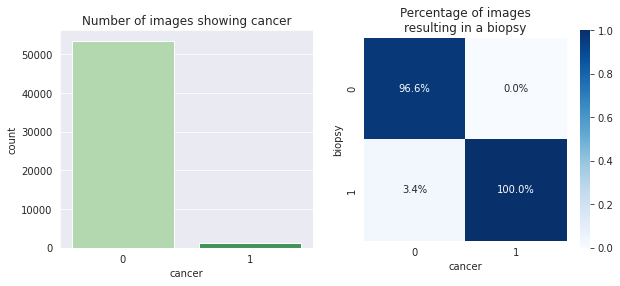

In [10]:
biopsy_counts = data.groupby('cancer')['biopsy'].value_counts().unstack().fillna(0)
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(data['cancer'], palette='Greens', ax=ax[0])
sns.heatmap(biopsy_perc, square=True, annot=True, fmt='.1%', cmap='Blues', ax=ax[1])
ax[0].set_title("Number of images showing cancer")
ax[1].set_title("Percentage of images\nresulting in a biopsy")
plt.show()

### Insights
* The number of sample images with cancer is very low compared to the number of healthy breast samples. It will be more difficult to make the model learn the desired pattern.
* All patients with a cancer had a biopsy
* Only a small percentage of images without cancer resulted in a biopsy

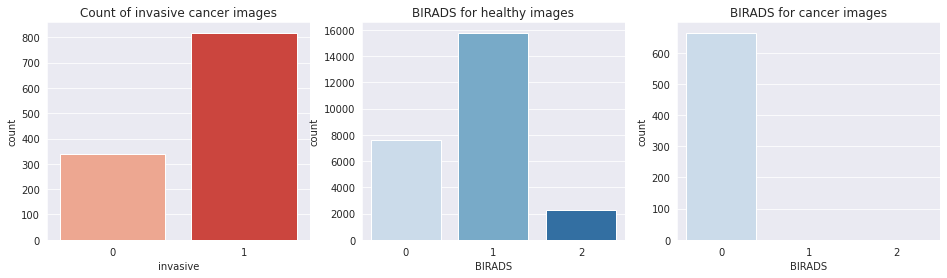

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data[data['cancer'] == True]['invasive'], ax=ax[0], palette='Reds')
sns.countplot(data[data['cancer'] == False]['BIRADS'], order=[0, 1, 2], ax=ax[1], palette='Blues')
sns.countplot(data[data['cancer'] == True]['BIRADS'], order=[0, 1, 2], ax=ax[2], palette='Blues')
ax[0].set_title("Count of invasive cancer images")
ax[1].set_title("BIRADS for healthy images")
ax[2].set_title("BIRADS for cancer images")
plt.show()

BIRADS value signification:
* 0: required follow-up
* 1: rated as negative for cancer
* 2: rated as normal

### Insights
* Most of the images with cancer are invasive
* A few healthy images led to a follow-up
* All cancer images needed a follow-up

## Machine IDs

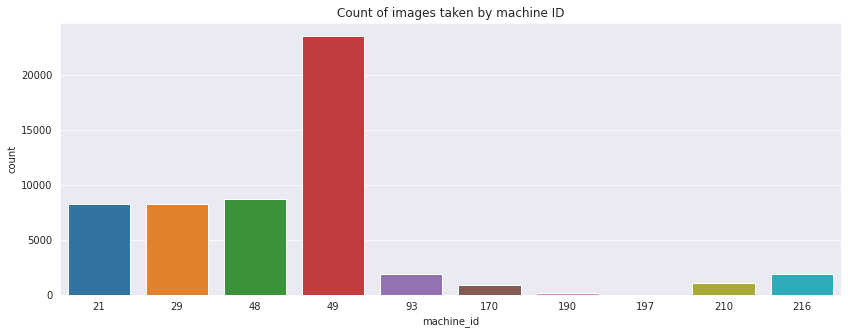

In [12]:
plt.figure(figsize=(14, 5))
sns.countplot(data['machine_id'])
plt.title("Count of images taken by machine ID")
plt.show()

### Insights
* The images were taken from 10 different machines
* Most of the images are from machine 49, 21, 29 and 48
* Machine difference can lead to image distribution difference

# Exploring the image data

### DICOM files
The image data is in DICOM format. **DICOM (Digital Imaging and Communications in Medicine)** is a standard for storing and transmitting medical images and related information.

It consists of a set of data elements that are organized into a file structure. These data elements contain information about the medical image, such as the patient's name and medical record number, the image modality (e.g., CT, MRI, X-ray), the date and time the image was taken, and the image itself. The image data can be stored in various formats, such as 8-bit or 16-bit grayscale, or 24-bit color.

In addition to the image data, the DICOM format also includes metadata that describes the characteristics of the image, such as the image resolution, the size of the image in pixels, and the orientation of the image. This metadata is important for accurately displaying and interpreting the image.

The DICOM format is widely used in the medical community for storing, sharing, and analyzing medical images. It is supported by a wide range of medical devices, such as scanners, modalities, and workstations, and is used in hospitals, clinics, and research facilities around the world.

In [13]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images'

## Getting all scans of a single patient

In [14]:
def load_patient_scans(path, patient_id):
    patient_path = path + '/' + str(patient_id)
    return [pydicom.dcmread(patient_path + '/' + file) for file in listdir(patient_path)]

We can now load all the scans for the first patient that we will use for exploring.

In [15]:
# Load all scans of the twelfth patient
patient_ids = data['patient_id'].unique()
scans = load_patient_scans(train_path, patient_ids[11])

## Raw pixelarrays

In order to make the images comparable, we need to normalize the values of the pixelarray distribution in HU.

### Hounsfield unit

The **Hounsfield unit (HU)** is a standard unit of measurement used in computed tomography (CT) imaging to describe the radiodensity of tissues and other structures within the body. The HU scale is used to assign a numerical value to the density of a particular tissue or structure, with higher values indicating more dense materials (such as bone) and lower values indicating less dense materials (such as fat or air).

Converting the radiographic image to Hounsfield units allows for more accurate and consistent interpretation of the image, as it allows for the comparison of densities between different structures within the body. This is important for identifying abnormalities and making diagnoses, as different tissues and structures have different densities that can be used to identify them on CT images.

Overall, the use of Hounsfield units in radiographic imaging allows for more precise and accurate interpretation of the image, and is an essential tool in medical imaging.

Example:
* Air : -1000
* Fat : -120 to -90
* Water : 0
* Muscle : +38 to +55
* Bone : +300 to +1900

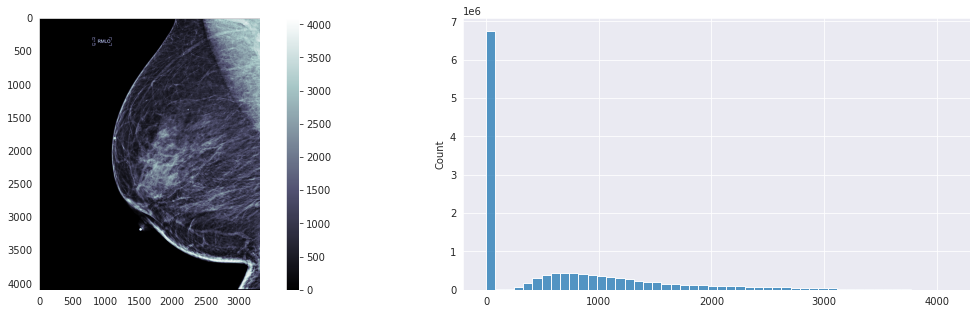

In [16]:
# Look at raw pixelarrays
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
im = ax[0].imshow(scans[0].pixel_array, cmap='bone')
ax[0].grid(False)
fig.colorbar(im, ax=ax[0])
sns.histplot(scans[0].pixel_array.flatten(), ax=ax[1], bins=50)
plt.show()

The value of the background is zero. This means that the raw pixelarray is not in HU. Some values are very large compared to what we would expect for soft tissues. The images must be converted to HU in order to have something consistant.

Let's dive deep into the different machine IDs.

In [17]:
def get_scan_info():
    modes, rows, cols = [], [], []
    machine_ids = data['machine_id'].unique()
    for m_id in machine_ids:
        m_id_modes, m_id_rows, m_id_cols = [], [], []
        print(f"Machine id {m_id} in progress")
        patient_ids = data[data['machine_id'] == m_id]['patient_id'].unique()
        for n in range(50):
            try:
                scan = load_patient_scans(train_path, patient_ids[n])[0]
                m_id_modes.append(mode(scan.pixel_array.flatten())[0][0])
                m_id_rows.append(scan.Rows)
                m_id_cols.append(scan.Columns)
            except IndexError:
                break
        modes.append(m_id_modes)
        rows.append(m_id_rows)
        cols.append(m_id_cols)
    return modes, rows, cols

In [18]:
modes, rows, cols = get_scan_info()

machine_ids = data['machine_id'].unique()
medians = [np.median(x) for x in modes]
stds = [np.std(x) for x in modes]
rows = [np.mean(x) for x in rows]
cols = [np.mean(x) for x in cols]
df = pd.DataFrame(data={'Machine ID': machine_ids, 'Mode (median)': medians, 'Mode (std)': stds, 'Rows (mean)': rows, 'Cols (mean)': cols})
df.astype(int).set_index('Machine ID').T

Machine id 29 in progress
Machine id 21 in progress
Machine id 216 in progress
Machine id 93 in progress
Machine id 49 in progress
Machine id 48 in progress
Machine id 170 in progress
Machine id 210 in progress
Machine id 190 in progress
Machine id 197 in progress


Machine ID,29,21,216,93,49,48,170,210,190,197
Mode (median),3524,0,0,0,0,0,0,1017,0,83
Mode (std),215,0,146,289,0,0,0,2,67,219
Rows (mean),5355,2776,2294,2831,3834,4096,3804,5072,2322,2213
Cols (mean),4915,2082,1914,2250,3066,3328,3036,3872,1931,1843


### Insights
* It seems that the pixel distribution is different based on the machine ID. In fact, the mode corresponds to the background pixels. Most of the time, this value is calibrated to 0 but for some machines (e.g. IDs 29 and 210), it is above a 3000 and 1000 respectively.
* The image size also depends on the machine. Again, machines 29 and 210 have a high resolution compared to others like machine IDs 216 and 197.
* It will be necessary to normalize the image size and the pixel values in order to train a robust model.

## Display examples for different machines

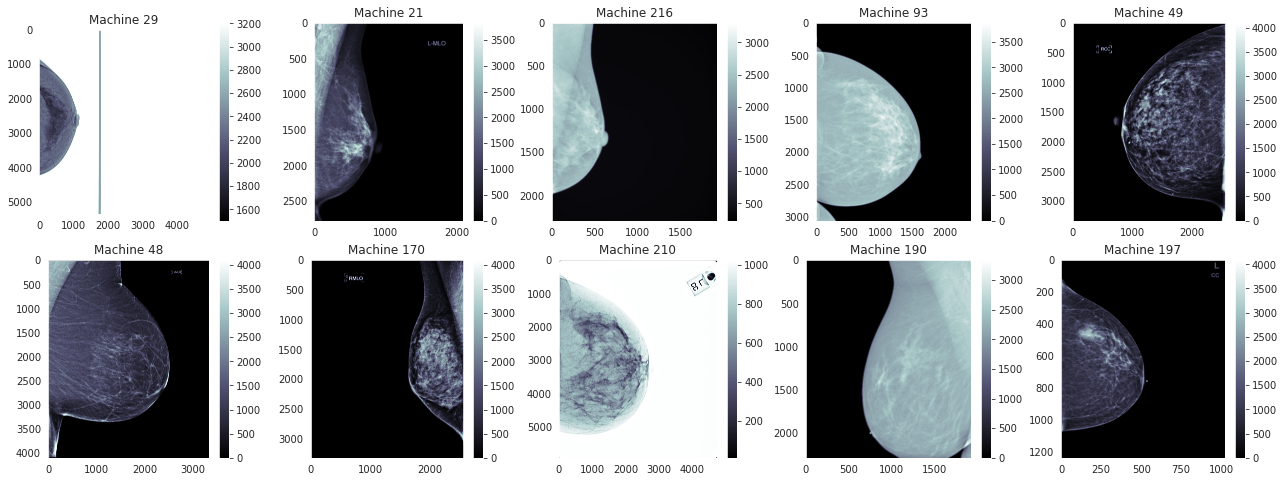

In [19]:
plt.figure(figsize=(22, 8))
for i, m_id in enumerate(machine_ids):
    patient_ids = data[data['machine_id'] == m_id]['patient_id'].unique()
    scan = load_patient_scans(train_path, patient_ids[0])[0] # Load first scan of first patient
    plt.subplot(2, 5, i+1)
    plt.imshow(scan.pixel_array, cmap='bone')
    plt.title(f"Machine {m_id}")
    plt.colorbar()
    plt.grid(False)
plt.show()

### Insights
* For machines 29 and 210, the background values seem to be switched. In other words, it appears to be the highest value (white color). For the other images, it appears to be the lowest value (black color). This should be taken into account during processing.
* These images are just one example for each machine. It could be also different for other examples.

## Images showing implants

In this dataset, there are scans of breasts with implants. It can be interesting to have a look at them and compare them with other scans.

In [20]:
m_id_implants = data[data['implant'] == 1]['machine_id'].unique()
print("Scans showing implents are from machines", m_id_implants)

Scans showing implents are from machines [ 49 170]


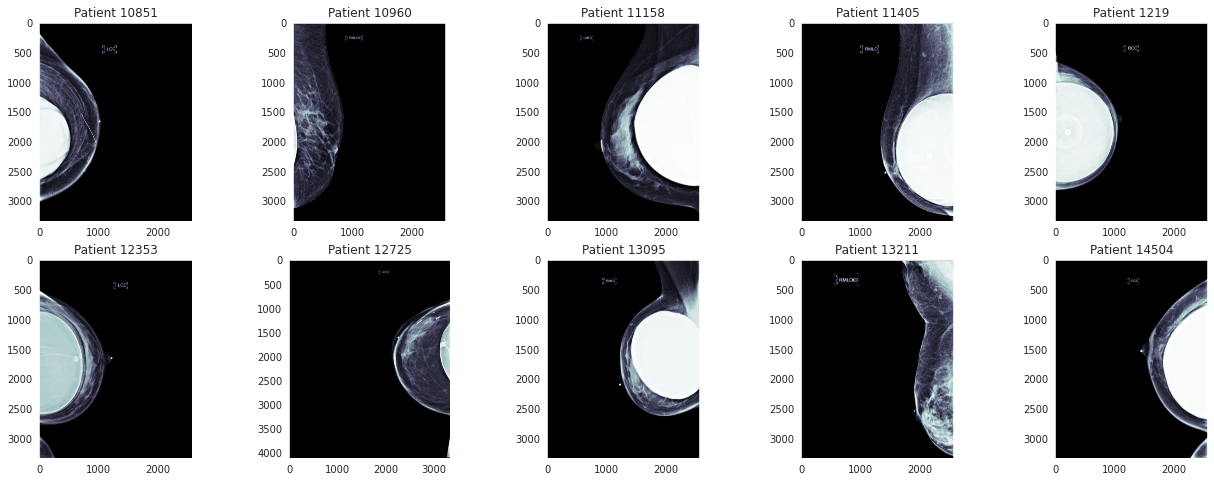

In [21]:
patient_ids = data[data['implant'] == 1]['patient_id'].unique()

# Display scans showing implants
plt.figure(figsize=(22, 8))
for i in range(10):
    scan = load_patient_scans(train_path, patient_ids[i])[0] # Load first scan of the patient
    plt.subplot(2, 5, i+1)
    plt.imshow(scan.pixel_array, cmap='bone')
    plt.title(f"Patient {patient_ids[i]}")
    plt.grid(False)
plt.show()

The implant is distinguished by the white mass in the breast. However, it is sometimes not very easy to see it like with patients 10960 and 13095.

Let's check all the scans of a single patient having implant.

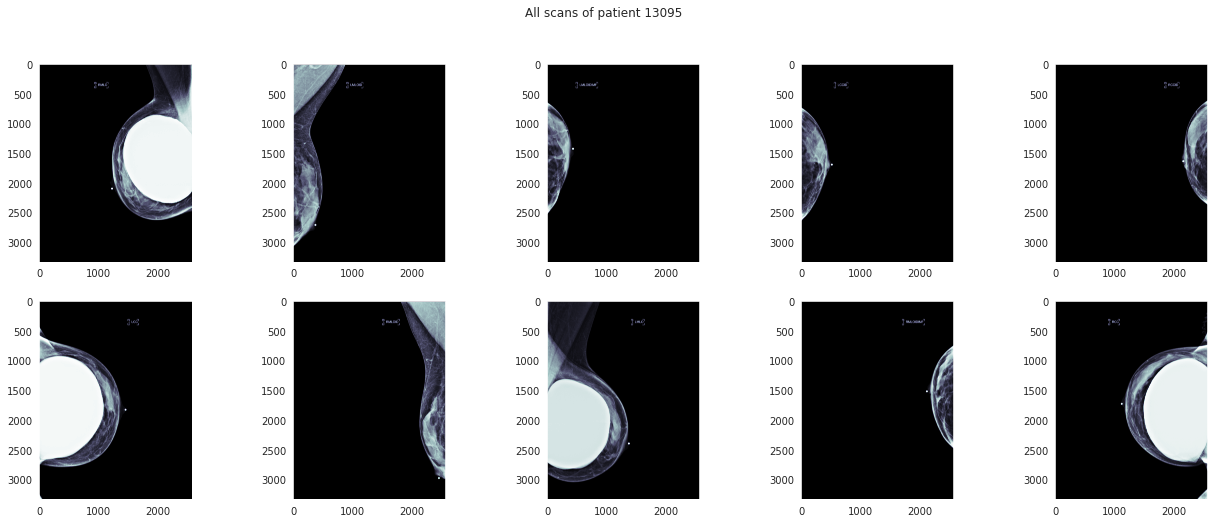

In [22]:
# Display scans of patient 13095
plt.figure(figsize=(22, 8))
scans = load_patient_scans(train_path, 13095)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(scans[i].pixel_array, cmap='bone')
    plt.grid(False)
plt.suptitle("All scans of patient 13095")
plt.show()

### Insights
* All the scans showing implants are from machines 49 and 170.
* The implants are sometimes only present on one side and not in both breasts for a given patient.
* The metadata does not specify the presence of implent for a scan but for a given patient. It is therefore likely that an image without an implant indicates its presence.

## Images with cancer

In [23]:
# Choose to display images with or without cancer
def display_cancer_or_not(cancer=True):
    cancer_scans = data[data['cancer'] == int(cancer)].sample(frac=1, random_state=0)
    plt.figure(figsize=(22, 10))
    for i in range(10):
        patient = str(cancer_scans.iloc[i][['patient_id']][0])
        file = str(cancer_scans.iloc[i][['image_id']][0]) + '.dcm'
        scan = pydicom.dcmread(train_path + '/' + patient + '/' + file)
        plt.subplot(2, 5, i+1)
        plt.imshow(scan.pixel_array, cmap='bone')
        plt.title(f"Patient {patient}\nScan {file}")
        plt.grid(False)
    plt.suptitle(f"Cancer = {cancer}")
    plt.show()

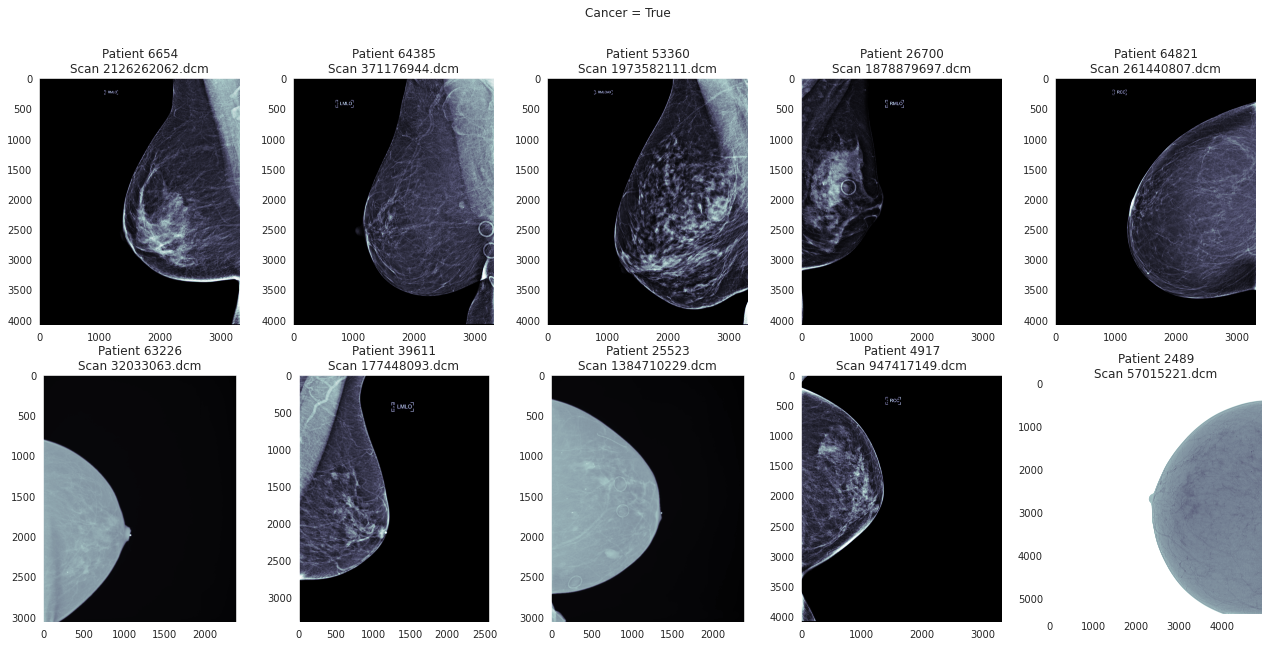

In [24]:
# Images with cancer
display_cancer_or_not(cancer=True)

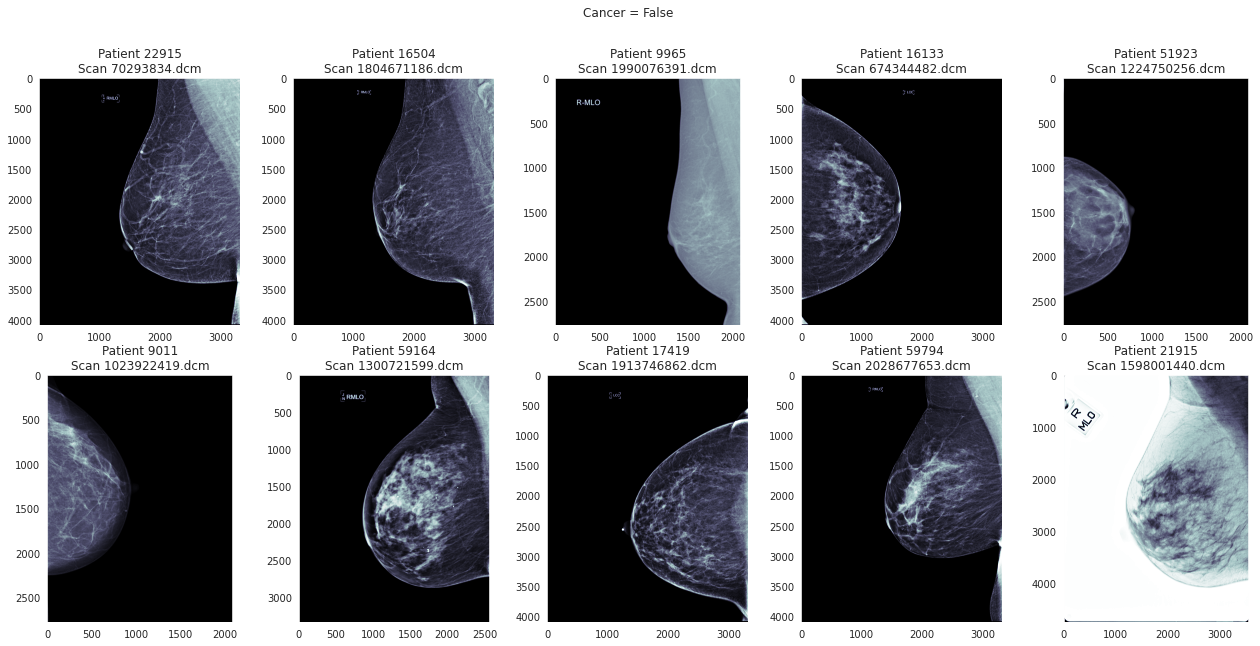

In [25]:
# Images without cancer
display_cancer_or_not(cancer=False)

### Insights
* It is impossible for me to distinguish by eye an image with cancer from a healthy image
* Again, there are images from different machine IDs which results in different pixel distributions

# Conclusion
* The dataset is heavily unbalanced between scans with and without cancer.
* Most of the patients are over 40 years old.
* Images are quite large and will need to be rescaled during preprocessing.
* Pixel distributions vary significantly depending on the machine ID used.
* The dataset is also unbalanced in terms of images showing implants.
* It is very difficult for a novice to distinguish a scan with cancer from a healthy one.

Performing EDA was very informative. It helped me understand what needs to be taken into consideration during the preprocessing steps.

**Thank you for reading. I welcome any feedback you may have. 👋**